Example notebook showing how to use the MCMC sampler (currently in development)

In [1]:
import os
import sys
import argparse
import torch
from getdist import plots, MCSamples
import getdist
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import emcee

In [2]:
path = os.path.realpath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, path)

In [3]:
from nnest import MCMCSampler
from nnest.likelihoods import *
from nnest.priors import *

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# Likelihood
#prior = UniformPrior(2, -5, 5)
#like = Himmelblau(2)
#prior = UniformPrior(2, -2, 12)
#like = Rosenbrock(2)
#prior = UniformPrior(2, -5, 5)
#like = Gaussian(2, 0.9)
#prior = UniformPrior(2, -15, 15)
#like = Eggbox(2)
#prior = UniformPrior(2, -3, 3)
#like = GaussianShell(2)
#prior = UniformPrior(2, -8, 8)
#like = GaussianMix(2)
prior = UniformPrior(2, [-7, -3], [7, 3])
like = DoubleGaussianShell(2, centers=[[-4.0, 0.0], [4.0, 0.0]])

In [6]:
sampler = MCMCSampler(like.x_dim, like, hidden_dim=16, num_blocks=3, flow='spline', prior=prior, run_num=1)

<bound method UniformPrior.sample of <nnest.priors.UniformPrior object at 0x7fd8b87b0a00>>
[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negat

In [7]:
init_samples = sampler._init_samples(temperature=1.0, num_chains=50, propose_scale=1.0)

[nnest.sampler] [INFO] Acceptance [0.1180] min ESS [0.2538] max ESS [1.1087] average jump distance [0.1026]


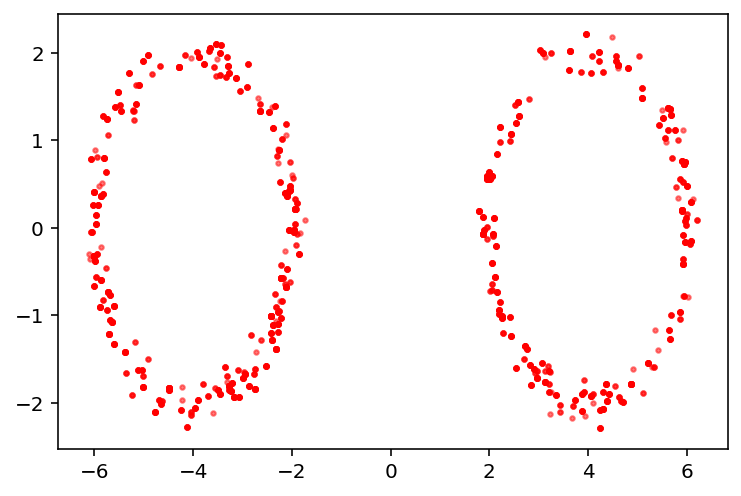

In [8]:
if like.x_dim == 2:
    plt.scatter(init_samples[:, 0], init_samples[:, 1], c='r', s=5, alpha=0.5)
    plt.show()

In [9]:
like.num_evaluations

7550

In [10]:
sampler.run(init_samples=init_samples)

[nnest.sampler] [INFO] Alpha [0.7071]
[nnest.trainer] [INFO] Number of training samples [1000]
[nnest.trainer] [INFO] Training jitter [0.1000]
[nnest.trainer] [INFO] Epoch [1] train loss [0.0297] validation loss [0.0284]
[nnest.trainer] [INFO] Epoch [50] train loss [0.0229] validation loss [0.0210]
[nnest.trainer] [INFO] Epoch [100] train loss [0.0201] validation loss [0.0176]
[nnest.trainer] [INFO] Epoch [150] train loss [0.0188] validation loss [0.0153]
[nnest.trainer] [INFO] Epoch [200] train loss [0.0186] validation loss [0.0143]
[nnest.trainer] [INFO] Epoch [250] train loss [0.0179] validation loss [0.0137]
[nnest.trainer] [INFO] Epoch [300] train loss [0.0182] validation loss [0.0134]
[nnest.trainer] [INFO] Epoch [350] train loss [0.0182] validation loss [0.0132]
[nnest.trainer] [INFO] Epoch [400] train loss [0.0179] validation loss [0.0130]
[nnest.trainer] [INFO] Epoch [450] train loss [0.0180] validation loss [0.0130]
[nnest.trainer] [INFO] Epoch [500] train loss [0.0178] valid

[nnest.sampler] [INFO] Acceptance [0.4265] min ESS [205.0073] max ESS [220.5082] average jump distance [0.3291]
[nnest.sampler] [INFO] MCMC step [4400], ncalls [14448] 
[nnest.sampler] [INFO] Acceptance [0.4255] min ESS [217.1668] max ESS [223.1514] average jump distance [0.3294]
[nnest.sampler] [INFO] MCMC step [4600], ncalls [15094] 
[nnest.sampler] [INFO] Acceptance [0.4244] min ESS [224.9585] max ESS [234.1502] average jump distance [0.3288]
[nnest.sampler] [INFO] MCMC step [4800], ncalls [15776] 
[nnest.sampler] [INFO] Acceptance [0.4247] min ESS [232.6994] max ESS [242.0837] average jump distance [0.3277]
[nnest.sampler] [INFO] MCMC step [5000], ncalls [16408] 
[nnest.sampler] [INFO] Acceptance [0.4243] min ESS [245.2451] max ESS [257.6630] average jump distance [0.3280]
ncall: 25359



In [11]:
samples = [sampler.samples[i, :, :].squeeze() for i in range(sampler.samples.shape[0])]
latent_samples = [sampler.latent_samples[i, :, :].squeeze() for i in range(sampler.latent_samples.shape[0])]
loglikes = [sampler.loglikes[i, :].squeeze() for i in range(sampler.loglikes.shape[0])]

In [12]:
mc = MCSamples(samples=samples, loglikes=loglikes)

Removed no burn in


In [13]:
print(mc.getEffectiveSamples())
print(mc.getMargeStats())
print(mc.getConvergeTests())

1239.5052485423096
Marginalized limits: 0.68; 0.95; 0.99

parameter   mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
param1     -7.7316385E-03  4.2957406E+00 -5.1629829E+00  4.9654553E+00  two   -6.1463028E+00  6.1183852E+00  two   -6.2175460E+00  6.1956494E+00  two     p_{1}
param2     -4.2250946E-02  1.4634076E+00 -2.1495837E+00  2.1263505E+00  two   -2.0926318E+00  2.0703666E+00  two   -2.1721326E+00  2.1635603E+00  two     p_{2}

Parameter autocorrelation lengths (effective number of samples N_eff = tot weight/weight length)

            Weight Length   Sample length           N_eff
param1           1.99E+01           19.88            1257
param2           1.92E+01           19.23            1300


mean convergence stats using remaining chains
param sqrt(var(chain mean)/mean(chain var))

param1        0.0703  p_{1}
param2        0.0749  p_{2}

var(mean)/mean(var) for eigenvalues of covari

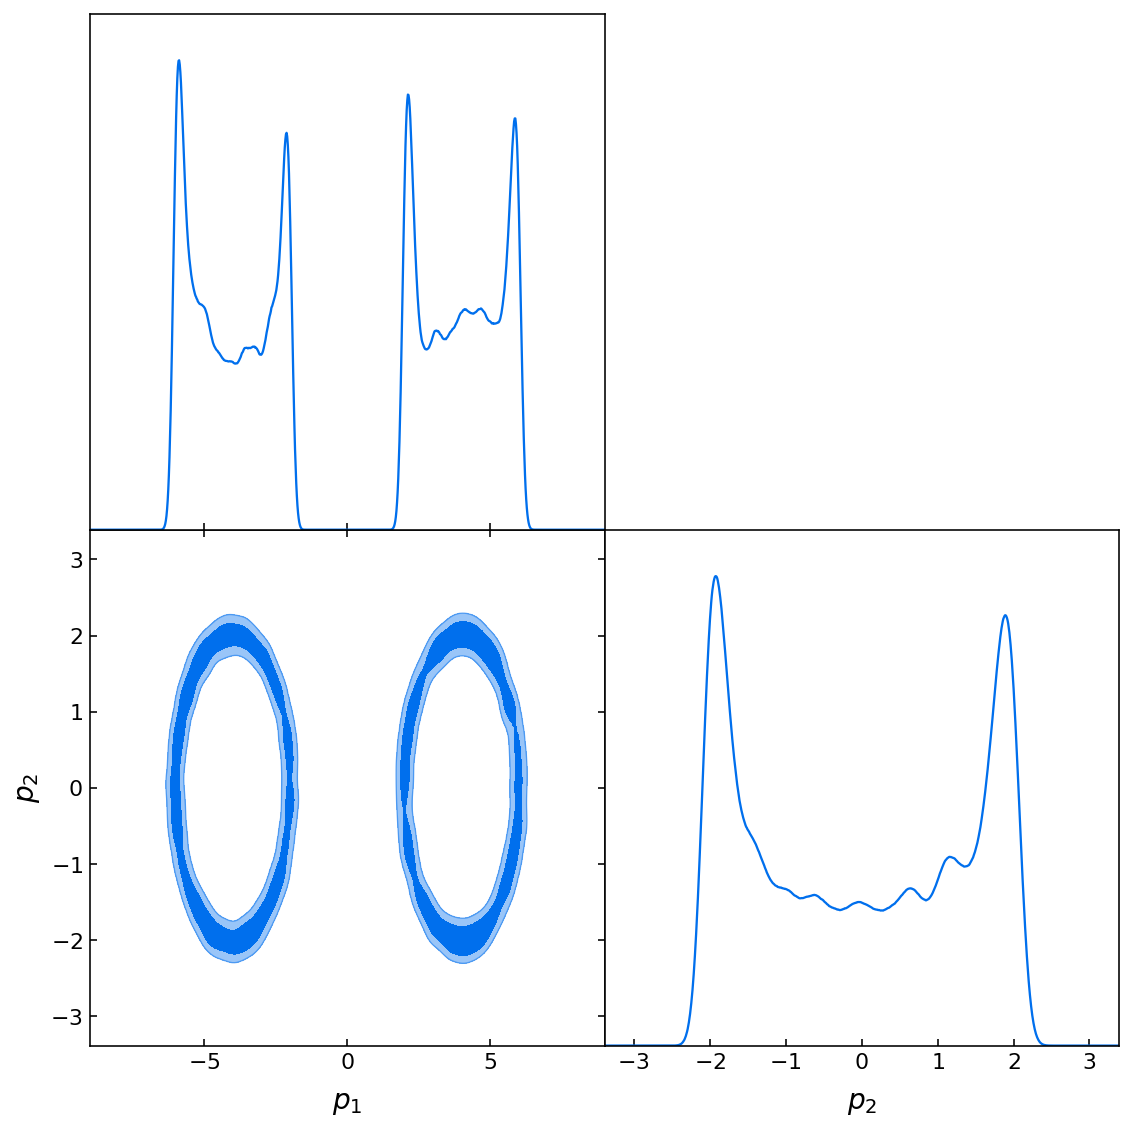

In [14]:
g = plots.getSubplotPlotter(width_inch=8)
g.triangle_plot(mc, filled=True)

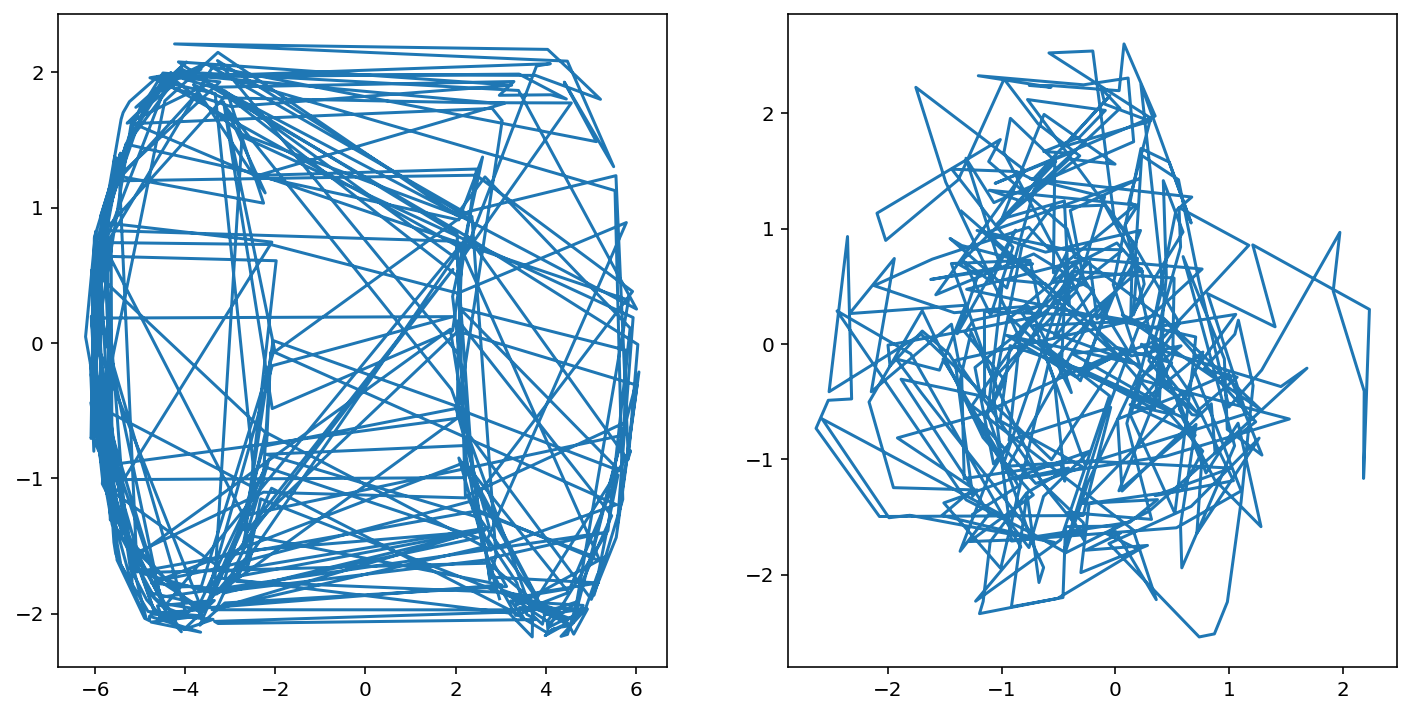

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(samples[0][0:1000,0], samples[0][0:1000,1])
ax[1].plot(latent_samples[0][0:1000,0], latent_samples[0][0:1000,1])
plt.show()

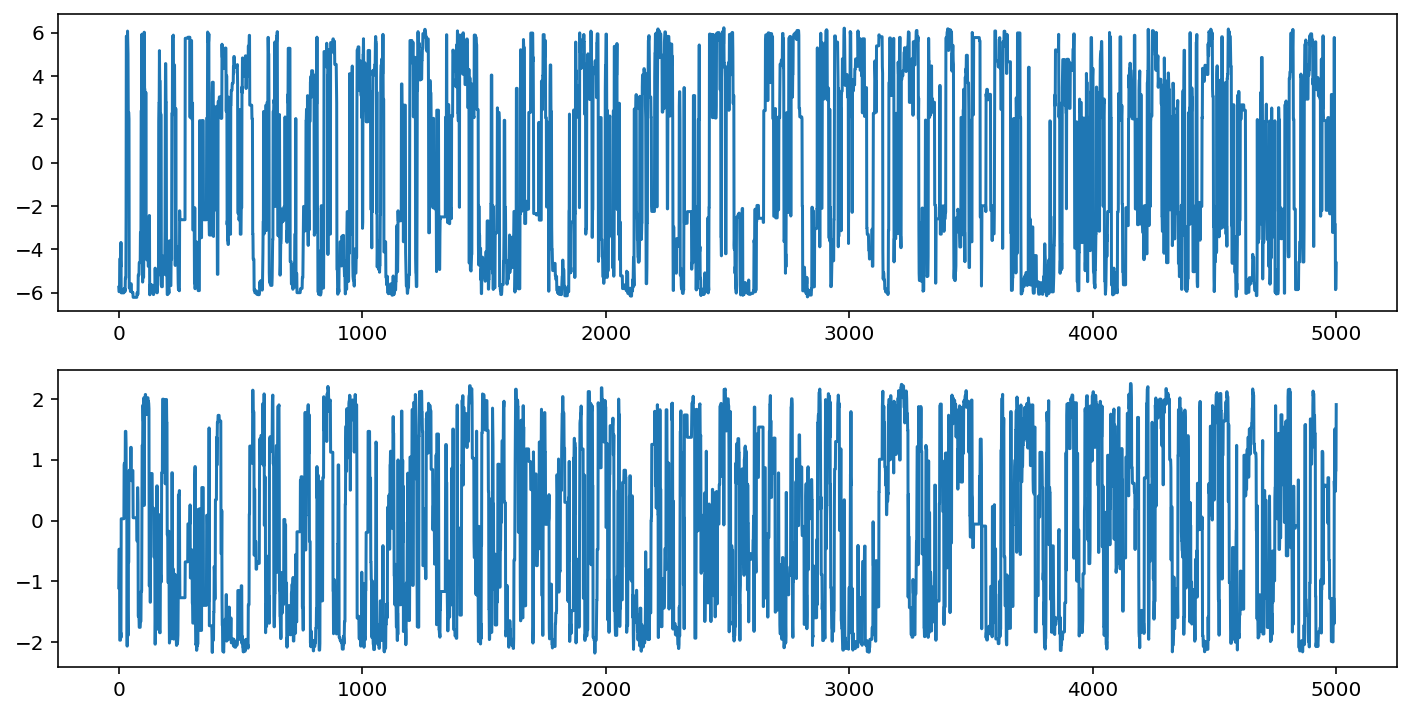

In [16]:
fig, ax = plt.subplots(like.x_dim, 1, figsize=(6*like.x_dim,6))
for i in range(like.x_dim):
    ax[i].plot(samples[0][:,i])
plt.show()